### Данные

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
   - лог сервера с данными о посещениях сайта Яндекс.Афиши (visits_log)
   - выгрузка всех заказов за этот период (orders_log)
   - статистика рекламных расходов (costs).

### Вопросы

1) На какой источник было потрачено больше всего денег за год?\
2) Найти средний LTV пользователей, которые впервые пришли до декабря 2017 года.\
3) Какая кагорта (по месяцам первого посещения) принесла больше всего
денег за полгода жизни?

### Содержание проекта

0\. Предобработка и иссследование данных (EDA)\
**1\. Вопрос 1\
2\. Вопрос 2**\
2\.1. Подход 1\
2\.2. Подход 2\
**3\. Вопрос 3**

## 0. Предобработка и иссследование данных (EDA)

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import random
import textwrap
%matplotlib inline

In [2]:
visits_log = pd.read_csv('~\\visits_log.csv')
orders_log = pd.read_csv('~\\orders_log.csv')
costs = pd.read_csv('~\\costs.csv')

In [3]:
visits_log.head(3)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


In [4]:
orders_log.head(3)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


In [5]:
costs.head(3)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


In [6]:
datasets = [visits_log,orders_log,costs]
for df in datasets:
    print(df.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     -----------

Приведем даты к корректному формату

In [7]:
for df in datasets:
    for col in list(df.columns):
        if ('Ts' in col) + ('dt' in col) > 0:
            df[col] = pd.to_datetime(df[col])

Также приведеим Uid пользователей к строковому виду и переименуем столбцы для удобства последующих джойнов.

In [8]:
visits_log = visits_log.astype({'Uid':'str'}).rename(columns={'Source Id':'source_id'})
orders_log = orders_log.astype({'Uid':'str'})

Отсортируем все датасеты в хронологическом порядке.

In [9]:
visits_log = visits_log.sort_values('Start Ts', ignore_index=1)
orders_log = orders_log.sort_values('Buy Ts', ignore_index=1)
costs = costs.sort_values(['dt', 'source_id'], ignore_index=1)

In [10]:
datasets = [visits_log,orders_log,costs]
for df in datasets:
    print(df.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  object        
 1   End Ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 13.7+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 

In [11]:
for df in datasets:
    print(df.describe(datetime_is_numeric=True).round(1), '\n')

                              End Ts  source_id                       Start Ts
count                         359400   359400.0                         359400
mean   2017-12-18 06:28:15.036205056        3.8  2017-12-18 06:17:32.010517760
min              2017-06-01 00:02:00        1.0            2017-06-01 00:01:00
25%              2017-10-15 09:45:45        3.0            2017-10-15 09:41:00
50%              2017-12-18 18:59:30        4.0            2017-12-18 18:46:00
75%              2018-02-28 10:08:15        5.0            2018-02-28 09:54:00
max              2018-06-01 01:26:00       10.0            2018-05-31 23:59:00
std                              NaN        1.9                            NaN 

                              Buy Ts  Revenue
count                          50415  50415.0
mean   2017-12-20 05:14:24.846176768      5.0
min              2017-06-01 00:10:00      0.0
25%              2017-10-13 17:28:00      1.2
50%              2017-12-21 14:12:00      2.5
75%        

Половина пользователей тратит на афише не более 2.5 долл. (около 150 руб.), 75% - не более 4.9 долл. (около 300 р.) Это комиссия Афиши за оплату мероприятий партнеров, которая в это время составляла 10% стоимости билета. При таком раскладе цифры вполне реальные.

Однако, судя по максимальному значению, есть выбросы.

Рассмотрим распределение размеров платежей подробнее

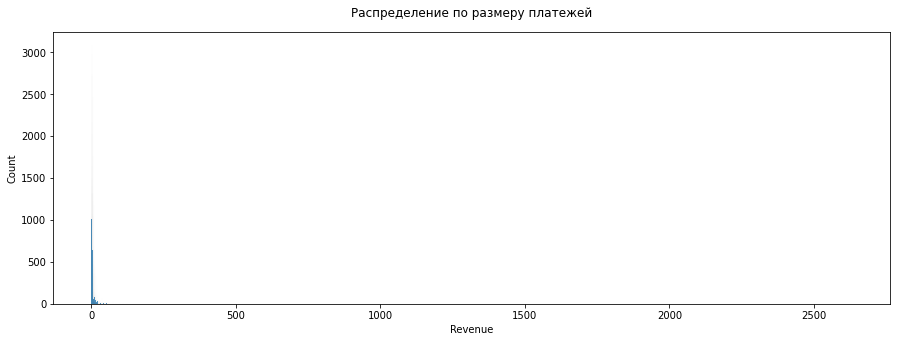

In [12]:
plt.figure(figsize=(15,5))
sns.histplot(data = orders_log,x = 'Revenue')
plt.title('Распределение по размеру платежей', pad=15)
plt.show()

Ограничимся платежами до 50 долл.

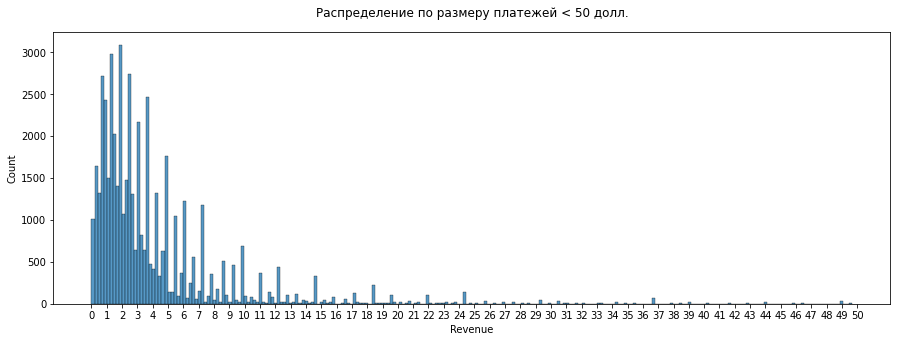

In [13]:
plt.figure(figsize=(15,5))
sns.histplot(data = orders_log.query('Revenue < 50'), x = 'Revenue')
plt.title('Распределение по размеру платежей < 50 долл.', pad=15)
plt.xticks(range(0,51))
plt.show()

На распределении наглядно видно, что абсолютное число платежей не превышают 10 долл.

В логах платежей есть нулевые суммы, рассмотрим их подробнее

In [14]:
orders_log.query('Revenue == 0').shape[0]

51

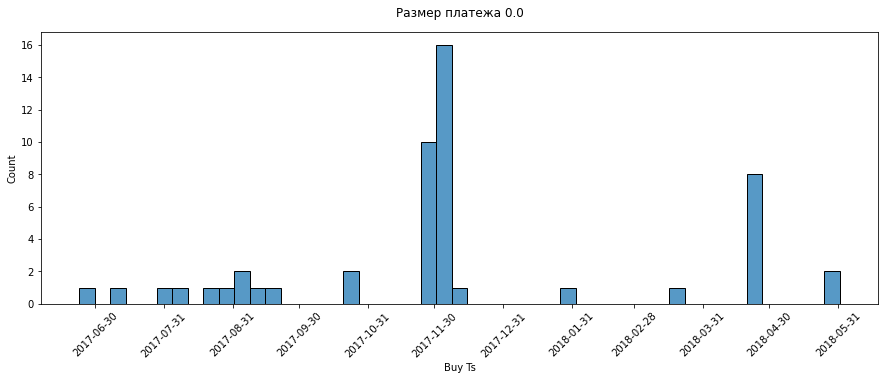

In [15]:
plt.figure(figsize=(15,5))
sns.histplot(data = orders_log.query('Revenue == 0'),x = 'Buy Ts', binwidth=7)\
.set_title('Размер платежа 0.0', pad=15)
plt.xticks(pd.date_range('2017-06-01', '2018-06-01', freq='M'), rotation=45)
plt.show()

In [16]:
orders_log.query('Revenue == 0')['Buy Ts'].dt.date.value_counts().head(5)

2017-11-30    6
2017-12-01    6
2017-11-28    5
2018-04-21    4
2017-12-02    3
Name: Buy Ts, dtype: int64

Большая часть нулевых платежей была совершена в последнюю неделю ноября - первую неделю декабря 2017.\
24 ноября 2017 была Черная пятница, скорее всего клиенты реализовали свои скидочные купоны или другие предложения от Яндекса с ограниченным сроком (неделя).

Запомним эту особенность данных.

Рассмотрим самые популярные размеры платежей

In [17]:
orders_log.Revenue.value_counts(normalize=1).mul(100).round(1).head(10).apply(str) + '%'

1.83    5.1%
2.44    4.9%
3.67    4.8%
1.22    4.4%
3.05    4.0%
4.89    3.3%
0.61    2.6%
4.28    2.4%
6.11    2.3%
7.33    2.3%
Name: Revenue, dtype: object

Некоторые размеры платежей составляют существенную часть всего массива. Это объясняется наличием популярных "круглых" цен на билет и фиксированной ставкой комиссии.

Сопоставим пользователей в датасетах по визитам и оплатам

In [18]:
print(f"Количество уникальных пользователей, которые есть в обоих датасетах: \
{len(set(visits_log['Uid'].unique()).intersection(set(orders_log['Uid'].unique())))}")

print(f"Количество уникальных пользователей, которые есть в orders_log: \
{len(orders_log['Uid'].unique())}")

print(f"Количество уникальных пользователей, которые есть в orders_log, но нет в visits_log: \
{len(set(orders_log['Uid'].unique()).difference(set(visits_log['Uid'].unique())))}")

print(f"Количество уникальных пользователей, которые есть в visits_log, но нет в orders_log: \
{len(set(visits_log['Uid'].unique()).difference(set(orders_log['Uid'].unique())))}")

Количество уникальных пользователей, которые есть в обоих датасетах: 36523
Количество уникальных пользователей, которые есть в orders_log: 36523
Количество уникальных пользователей, которые есть в orders_log, но нет в visits_log: 0
Количество уникальных пользователей, которые есть в visits_log, но нет в orders_log: 191646


Все в порядке, все платящие пользователи есть в датасете по визитам.

Рассмотрим динамику посещений и оплат по времени.

In [19]:
(min(visits_log['Start Ts'].min(), orders_log['Buy Ts'].min()),
min(visits_log['End Ts'].max(), orders_log['Buy Ts'].max()))

(Timestamp('2017-06-01 00:01:00'), Timestamp('2018-06-01 00:02:00'))

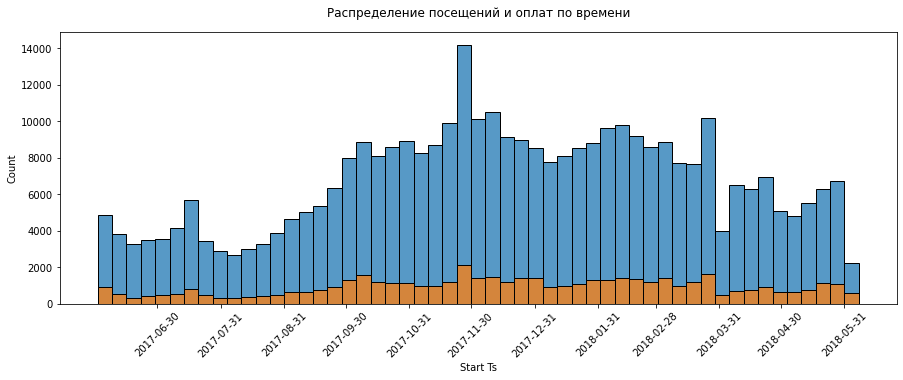

In [20]:
plt.figure(figsize=(15,5))
sns.histplot(data = visits_log, x = 'Start Ts', binwidth=7)
sns.histplot(data = orders_log, x = 'Buy Ts', binwidth=7, color='tab:orange')
plt.title('Распределение посещений и оплат по времени', pad=15)
plt.xticks(pd.date_range('2017-06-01', '2018-06-01', freq='M'), rotation=45)
plt.show()

Платежи осуществлялись примерно пропорционально количеству визитов.

Рассмотрим статистику по числу уникальных пользователей по месяцам.

### !!! Добавить новых пользователей

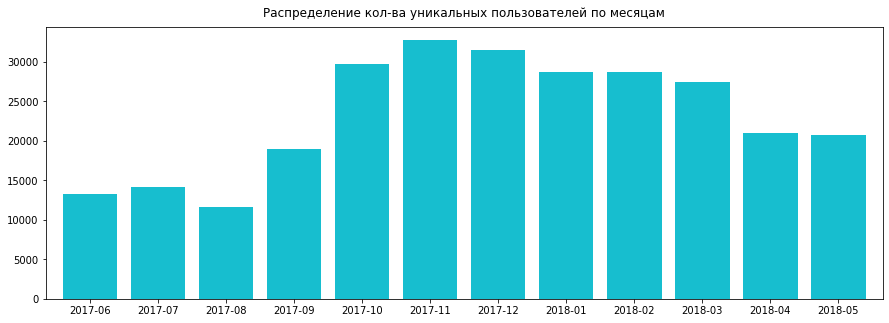

In [21]:
visits_log.groupby(visits_log['Start Ts'].dt.to_period('M')).agg({'Uid':'nunique'})\
.plot(kind='bar', width=0.8, color='tab:cyan', figsize=(15,5))\
.set_title('Распределение кол-ва уникальных пользователей по месяцам', pad=10)
plt.legend().remove()
plt.xticks(rotation=0)
plt.xlabel('')
plt.show()

В плане количества уникальных пользователей все ожидаемо - крупные города с большим количеством мест для досуга пустеют в летние месяцы из-за отпусков, каникул и тд., это напрямую влияет на количество пользователей Афиши.

Рассмотрим распределение пользователей по времени, проведенному на сайте.

In [22]:
((visits_log['End Ts'] - visits_log['Start Ts']).dt.total_seconds() / 60).quantile([0,0.5,0.95,1])

0.00    -46.0
0.50      5.0
0.95     38.0
1.00    711.0
dtype: float64

In [23]:
visits_log[(visits_log['End Ts'] - visits_log['Start Ts']).dt.total_seconds() < 0]

,Device,End Ts,source_id,Start Ts,Uid
298796,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
298797,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Есть 2 пользователя с временем начала сессии позднее времени окончания

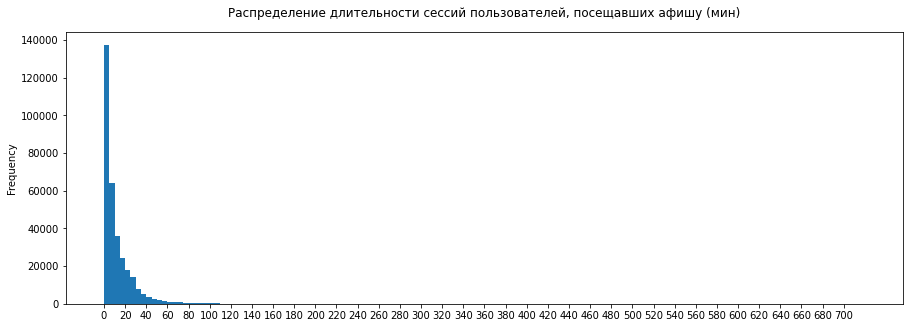

In [24]:
((visits_log['End Ts'] - visits_log['Start Ts']).dt.total_seconds() / 60).loc[lambda x : x > 0]\
.plot(kind='hist', figsize=(15,5), bins=range(0, 721, 5))
plt.title('Распределение длительности сессий пользователей, посещавших афишу (мин)', pad=15)
plt.xticks(range(0,720,20))
plt.show()

Рассмотрим левую часть ближе.

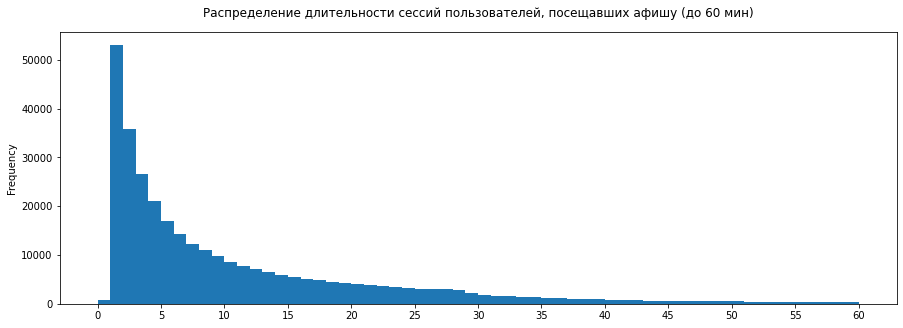

In [25]:
((visits_log['End Ts'] - visits_log['Start Ts']).dt.total_seconds() / 60).loc[lambda x : (x > 0)&(x < 60)]\
.plot(kind='hist', figsize=(15,5), bins=range(0, 61, 1))
plt.title('Распределение длительности сессий пользователей, посещавших афишу (до 60 мин)', pad=15)
plt.xticks(range(0,61,5))
plt.show()

In [26]:
((visits_log['End Ts'] - visits_log['Start Ts']).dt.total_seconds() / 60).loc[lambda x : x > 0]\
.quantile([0,0.5,0.75,0.95,1]).round(1)

0.00      0.3
0.50      6.0
0.75     15.0
0.95     40.0
1.00    711.0
dtype: float64

Половина пользователей провела на Афише не более 6 мин, 75% - не более 15 мин. Максимальная длительность сессии - 11 ч 51 мин. Посмотрим данные этого пользователя.

In [27]:
visits_log[(visits_log['End Ts'] - visits_log['Start Ts']).dt.total_seconds() / 60 > 700]

,Device,End Ts,source_id,Start Ts,Uid
178984,desktop,2017-12-18 22:43:00,3,2017-12-18 10:52:00,15566184277200431914


In [28]:
orders_log.query('Uid == "15566184277200431914"')

,Buy Ts,Revenue,Uid


Он просто приценивался почти 12 часов) Ну а если серьезно, скорее всего он забыл закрыть вкладку

Вернемся к пользователям с некорректным временем начала/окончания сессий.

In [29]:
visits_log[(visits_log['End Ts'] - visits_log['Start Ts']).dt.total_seconds() < 0]

,Device,End Ts,source_id,Start Ts,Uid
298796,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
298797,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Если у данных пользователей переставить начало и конец сессии местами, получится весьма похожее на реальное время, проведенное на платформе. Примем допущение, что такие ошибки периодически случаются и напишем функцию для их исправления. 

In [30]:
def time_exchange_to_correct(df,start_col_name,end_col_name):
    condition_mapping = (df[end_col_name] - df[start_col_name]).dt.total_seconds() < 0
    df = df.astype({start_col_name:'str',end_col_name:'str'})
    df.loc[condition_mapping, [start_col_name, end_col_name]] = \
    (df.loc[condition_mapping, [end_col_name, start_col_name]].values)
    df[start_col_name] = pd.to_datetime(df[start_col_name])
    df[end_col_name] = pd.to_datetime(df[end_col_name])
    return df

In [31]:
visits_log = time_exchange_to_correct(visits_log, 'Start Ts', 'End Ts')

In [32]:
visits_log.loc[[4181,177972],:]

,Device,End Ts,source_id,Start Ts,Uid
4181,touch,2017-06-07 09:42:00,4,2017-06-07 09:38:00,17840522004183008393
177972,desktop,2017-12-17 13:50:00,3,2017-12-17 13:44:00,1833425497048604561


Некорректные значения начала и конца сессии исправлены.

Попробуем предположить, какая модель оплаты рекламы у Афиши была по каждому рекламному источнику.

In [33]:
costs['source_id'].value_counts().sort_index()

1     363
2     363
3     363
4     363
5     364
9     363
10    363
Name: source_id, dtype: int64

Расходы по всем рекламным источникам осуществлялись ежедневно.

In [34]:
visits_log['source_id'].value_counts().sort_index()

1      34121
2      47626
3      85610
4     101794
5      66905
6          6
7         36
9      13277
10     10025
Name: source_id, dtype: int64

In [35]:
set(visits_log['source_id'].unique()).difference(set(costs['source_id'].unique()))

{6, 7}

В датасете по посещениям есть источники 6,7, по которым нет данных о рекламных расходах. Будем считать их органическим трафиком.

Агрегируем данные по рекламным расходам, визитам, платежам по дням и рассмотрим кореляции между показателями, чтобы определить модель оплаты рекламы, которую использует Афиша.

Рассчитаем в течение (или после) какой сессии пользователи совершили оплату и подтянем источник соответствующего визита к данным по оплате.

In [36]:
orders_log['Buy Ts'].max() + dt.timedelta(1)

Timestamp('2018-06-02 00:02:00')

In [37]:
max_dt = orders_log['Buy Ts'].max()
visits_log['next_session_start'] = visits_log.groupby('Uid')['Start Ts'].shift(-1).fillna(max_dt + dt.timedelta(1))
visits_log.sort_values(['Uid', 'Start Ts']).head()

,Device,End Ts,source_id,Start Ts,Uid,next_session_start
155179,desktop,2017-12-01 15:15:00,3,2017-12-01 15:11:00,10000171586432207426,2018-06-02 00:02:00
261393,desktop,2018-02-21 16:36:00,3,2018-02-21 16:01:00,10000344846682484395,2018-06-02 00:02:00
51655,desktop,2017-09-05 20:47:00,3,2017-09-05 20:22:00,1000036778515242839,2018-06-02 00:02:00
57040,touch,2017-09-13 09:23:00,4,2017-09-13 09:12:00,10000460875579931334,2018-06-02 00:02:00
199731,desktop,2018-01-03 19:00:00,4,2018-01-03 18:39:00,10000558740593440652,2018-06-02 00:02:00


In [38]:
def source_of_purchase(df):
    if df['Buy Ts'] >= df['Start Ts'] and df['Buy Ts'] < df['next_session_start']:
        return True

In [39]:
orders_log.shape[0]

50415

In [40]:
orders_log = orders_log.merge(visits_log, how='left', on='Uid')
orders_log = orders_log[orders_log.apply(lambda x: source_of_purchase(x), 1) == True]
orders_log.head()

,Buy Ts,Revenue,Uid,Device,End Ts,source_id,Start Ts,next_session_start
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2018-06-02 00:02:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2018-06-02 00:02:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2018-06-02 00:02:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2018-06-02 00:02:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2018-06-02 00:02:00


In [41]:
orders_log.shape[0]

50415

Рассчитаем показатели рекламных расходов, визитов на сайт, количество и сумму заказов по датам по каждому рекламному источнику.

In [42]:
#рекламные расходы по по каждому рекламному источнику по дням уже содержатся в датасете costs
s1 = costs.iloc[:,[1,0,2]]
s1['dt'] = s1['dt'].dt.to_period('d')

#считаем количество переходов по каждому рекламному источнику по дням
s2 = visits_log.query('source_id not in [6,7]').groupby([visits_log['Start Ts'].dt.to_period('d'), 'source_id'])\
.agg({'Uid':'count'}).reset_index().rename(columns={'Start Ts':'dt','Uid':'visits'})

#считаем количество и сумму платежей по дням и источникам
s3 = orders_log.query('source_id not in [6,7]').groupby([orders_log['Buy Ts'].dt.to_period('d'), 'source_id'])\
.agg({'Revenue':['count','sum']})
#доходы за 2018-06-01 учитываем в показателе по 2018-05-31 по соответствующему источнику
s3.loc[('2018-05-31', 4),('Revenue', 'count')] = s3.loc[('2018-05-31', 4),('Revenue', 'count')].values + \
s3.loc[('2018-06-01', 4),('Revenue', 'count')].values
s3.loc[('2018-05-31', 4),('Revenue', 'sum')] = s3.loc[('2018-05-31', 4),('Revenue', 'sum')].values + \
s3.loc[('2018-06-01', 4),('Revenue', 'sum')].values
s3.columns = [col[0]+'_'+col[1] if len(col) == 2 else col for col in s3.columns]
s3 = s3.iloc[0:-1:1, :].reset_index()\
.rename(columns={'Buy Ts':'dt', 'Revenue_count':'orders', 'Revenue_sum':'Revenue'})

In [43]:
for df in [s1,s2,s3]:
    print(df.head(2), '\n')

           dt  source_id   costs
0  2017-06-01          1   75.20
1  2017-06-01          2  132.56 

           dt  source_id  visits
0  2017-06-01          1      70
1  2017-06-01          2      85 

           dt  source_id  orders  Revenue
0  2017-06-01          1      20   171.71
1  2017-06-01          2      13    20.10 



Объединим полученные датасеты и посчитаем взаимные корреляции отдельно по каждому источнику.

In [44]:
report_by_dt = s1.merge(s2, how='left', on=['dt','source_id']).merge(s3, how='left', on=['dt','source_id'])
report_by_dt.head(3)

,dt,source_id,costs,visits,orders,Revenue
0,2017-06-01,1,75.20,70.0,20.0,171.71
1,2017-06-01,2,132.56,85.0,13.0,20.10
2,2017-06-01,3,349.38,185.0,34.0,111.89


In [45]:
sources = list(report_by_dt['source_id'].unique())
for source in sources:
    print(f'Источник {source}',
          report_by_dt.query('source_id == @source')[['costs','visits','orders','Revenue']].corr()['costs'],
          sep='\n', end = '\n\n')

Источник 1
costs      1.000000
visits     0.768649
orders     0.680442
Revenue    0.515120
Name: costs, dtype: float64

Источник 2
costs      1.000000
visits     0.766331
orders     0.643410
Revenue    0.301235
Name: costs, dtype: float64

Источник 3
costs      1.000000
visits     0.735036
orders     0.653855
Revenue    0.502874
Name: costs, dtype: float64

Источник 4
costs      1.000000
visits     0.310774
orders     0.296195
Revenue    0.277936
Name: costs, dtype: float64

Источник 5
costs      1.000000
visits     0.722496
orders     0.639818
Revenue    0.379380
Name: costs, dtype: float64

Источник 9
costs      1.000000
visits     0.425217
orders     0.400794
Revenue    0.351301
Name: costs, dtype: float64

Источник 10
costs      1.000000
visits     0.405247
orders     0.283701
Revenue    0.170427
Name: costs, dtype: float64



Ни по одному источнику нет корелляции, близкой к 1, однако есть источники с показателями корелляции по визитам, близкими к 0.8.

Отсутствие очень высокой корелляции между переменными скорее всего обусловлено динамическим ценообразованием на рекламных аукционах - чем изменчивее спрос на рекламу на определенной площадке или для определенного сегмента, тем изменчивее и цена, и тем меньше коэффициент корелляции.

По итогам корелляционного анализа можно предположить, что источники 1,2,3,5 работают по модели CPC (Cost-per-Click), так как корелляция между рекламными расходами и количеством визитов по ним достаточно высока. 

Остальные источники, вероятно, работают не по CPC и не по CPS (Cost-per-Sales) моделям. Для установления моделей оплаты рекламы по ним необходимо больше данных по целевым действиям на сайте, показам или просмотрам (видео) объявлений.

Рассмотрим динамику расходов и доходов по месяцам.

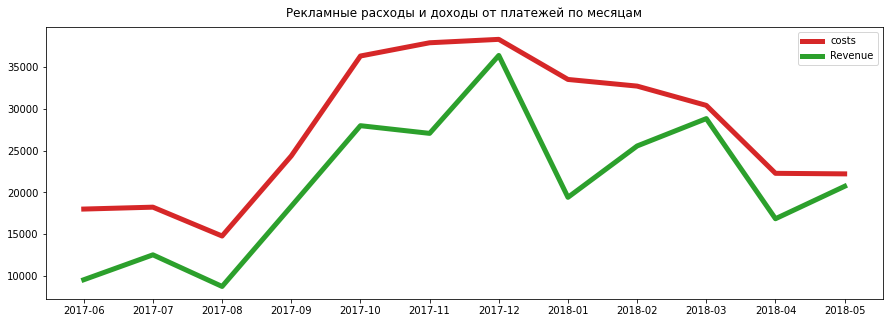

In [46]:
s = report_by_dt.groupby(report_by_dt['dt'].apply(str).str[0:7]).agg({'costs':'sum','Revenue':'sum'})
s.plot(figsize = (15,5), color=['tab:red','tab:green'], linewidth=5)
plt.title('Рекламные расходы и доходы от платежей по месяцам', pad=10)
plt.xticks(ticks=range(0,12), labels = list(s.index))
plt.xlabel('')
plt.show()

Общие рекламные расходы стабильно не окупаются)

И это несмотря на то, что мы даже не исключали пользователей с аномально высокими платежами.

Посмотрим по рекламным источникам.

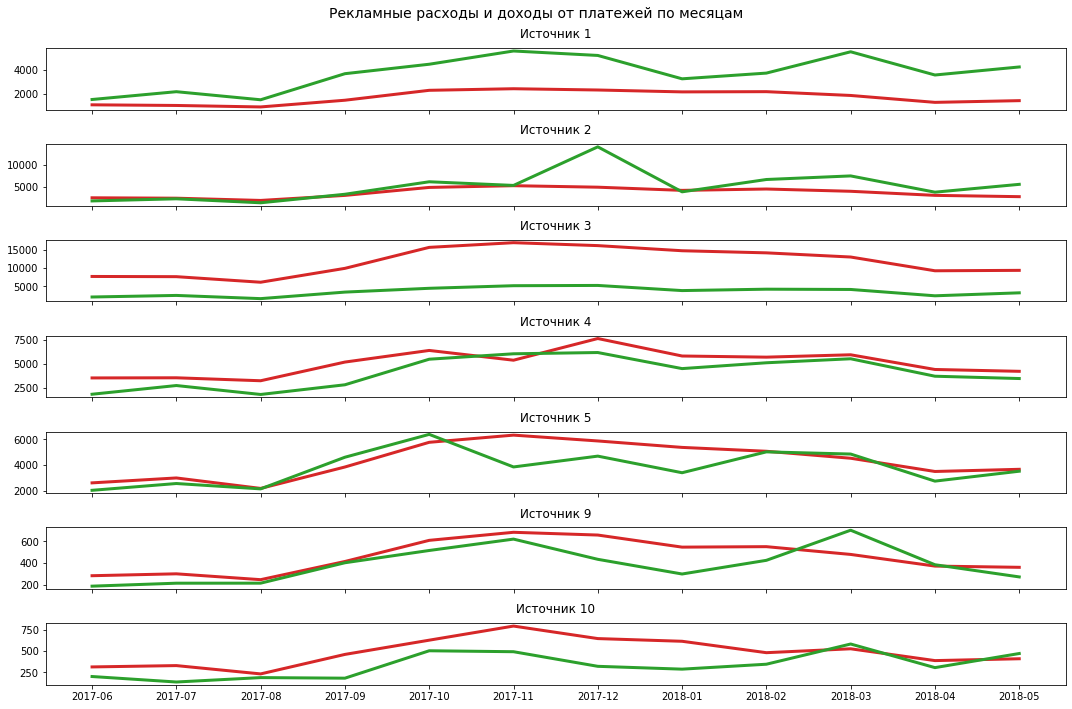

In [47]:
fig, ax = plt.subplots(len(report_by_dt['source_id'].unique()),1, sharex=True, figsize=(15,10))
plt.suptitle('Рекламные расходы и доходы от платежей по месяцам', fontsize=14)
sources = list(report_by_dt['source_id'].unique())
for i in range(len(sources)): 
    s = report_by_dt.query('source_id == @sources[@i]').groupby(report_by_dt['dt'].apply(str).str[0:7])\
    .agg({'costs':'sum','Revenue':'sum'})
    ax[i] = s.plot(color=['tab:red','tab:green'], linewidth=3, ax = ax[i])
    ax[i].set_title(f'Источник {sources[i]}', pad=10)
    ax[i].set_xticks(ticks=range(0,12), labels = list(s.index))
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
plt.tight_layout()
plt.show()

Только источник 1 стабильно приносил прибыль за последний год, источник 2 - с переменным успехом, остальные убыточны.

Аналогично рассмотрим визиты и заказы.

In [48]:
s = report_by_dt.groupby(report_by_dt['dt'].apply(str).str[0:7]).agg({'visits':'sum','orders':'sum'})
s['visits_to_orders_%'] = round(s['orders'] *100 / s['visits'], 1)
s

,visits,orders,visits_to_orders_%
dt,,,
2017-06,16503.0,2354.0,14.3
2017-07,17825.0,2363.0,13.3
2017-08,14353.0,1806.0,12.6
2017-09,23903.0,3387.0,14.2
2017-10,37898.0,5679.0,15.0
2017-11,43967.0,5659.0,12.9
2017-12,41973.0,6218.0,14.8
2018-01,36934.0,4721.0,12.8
2018-02,37177.0,5281.0,14.2


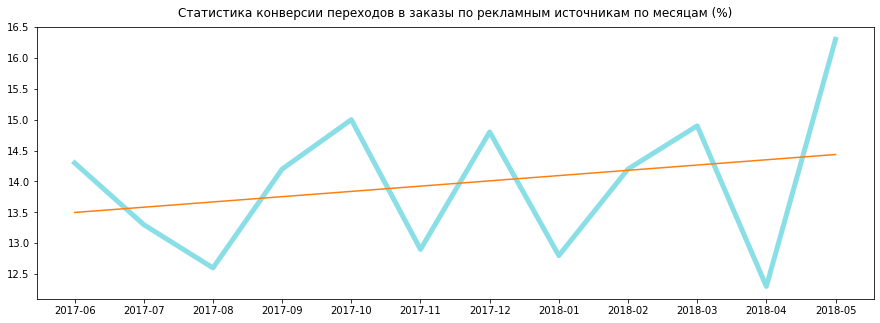

In [49]:
s = report_by_dt.groupby(report_by_dt['dt'].apply(str).str[0:7]).agg({'visits':'sum','orders':'sum'})
s['visits_to_orders'] = round(s['orders'] *100 / s['visits'], 1)
s['visits_to_orders'].plot(figsize = (15,5), color='tab:cyan', alpha=0.5, linewidth=5)
plt.title('Статистика конверсии переходов в заказы по рекламным источникам по месяцам (%)', pad=10)
plt.xticks(ticks=range(0,12), labels = list(s.index))
#plt.yticks(range(0,45000+1,5000))
plt.xlabel('')

z = np.polyfit(range(0,12), s['visits_to_orders'], 1)
p = np.poly1d(z)

plt.plot(range(0,12), p(range(0,12)), color='tab:orange', alpha=1)

plt.show()

Довольно интересная статистика конверсий переходов в заказы. Конверсия стремительно выросла в последнем месяце, за счет чего вырисовывается положительный тренд. 

Но сама динамика очень непостоянна, и возможно этот скачок связан с аномальным числом заказов от нескольких клиентов. В рамках данного проекта не будем углубляться в этот вопрос.

Посмотрим по рекламным кампаниям.

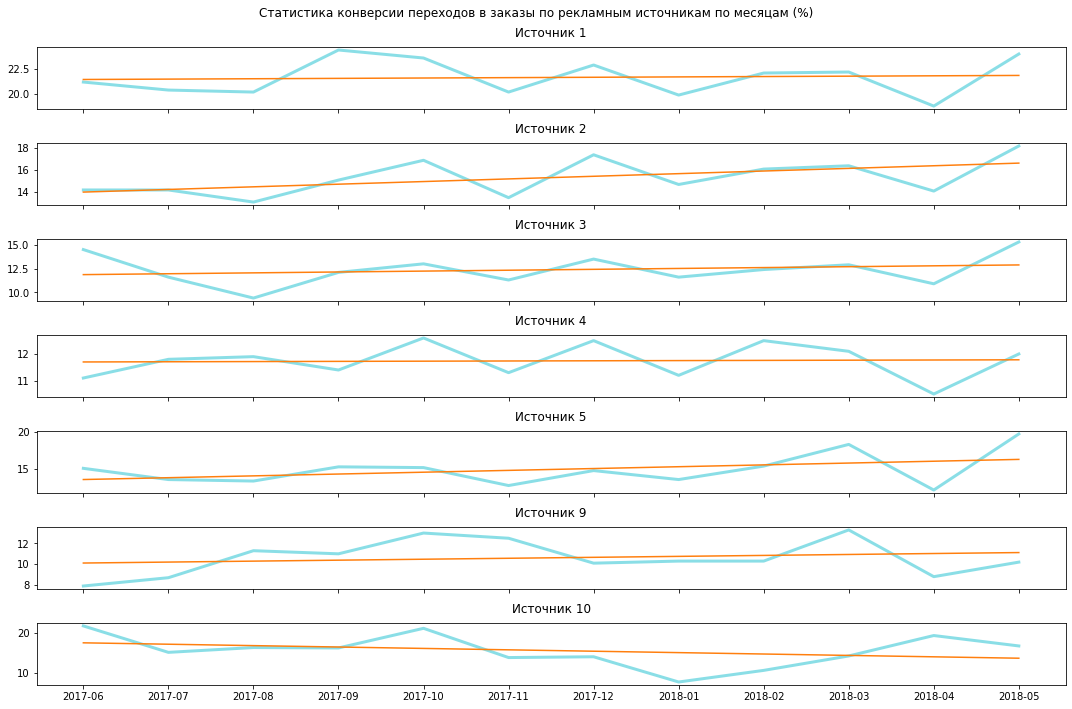

In [50]:
fig, ax = plt.subplots(len(report_by_dt['source_id'].unique()),1, sharex=True, figsize=(15,10))
plt.suptitle('Статистика конверсии переходов в заказы по рекламным источникам по месяцам (%)')
sources = list(report_by_dt['source_id'].unique())
for i in range(len(sources)): 
    s = report_by_dt.query('source_id == @sources[@i]').groupby(report_by_dt['dt'].apply(str).str[0:7])\
    .agg({'visits':'sum','orders':'sum'})
    s['visits_to_orders'] = round(s['orders'] *100 / s['visits'], 1)
    s = s['visits_to_orders']
    ax[i] = s.plot(color='tab:cyan', alpha=0.5, linewidth=3, ax = ax[i])
    ax[i].set_title(f'Источник {sources[i]}', pad=10)
    ax[i].set_xticks(ticks=range(0,12), labels = list(s.index))
    ax[i].set_xlabel('')
    z = np.polyfit(range(0,12), s, 1)
    p = np.poly1d(z)

    ax[i].plot(range(0,12), p(range(0,12)), color='tab:orange', alpha=1)
plt.tight_layout()
plt.show()

Аналогичная картина по источникам: каждый колебался в своих пределах. Источники 1,2 давали стабильно высокую конверсию, конверсия источника 10 колебалась в максимально широких пределах.

Общий разведывательный анализ завершен. Начнем отвечать на вопросы.

### Вопрос 1

1) На какой источник было потрачено больше всего денег за год?

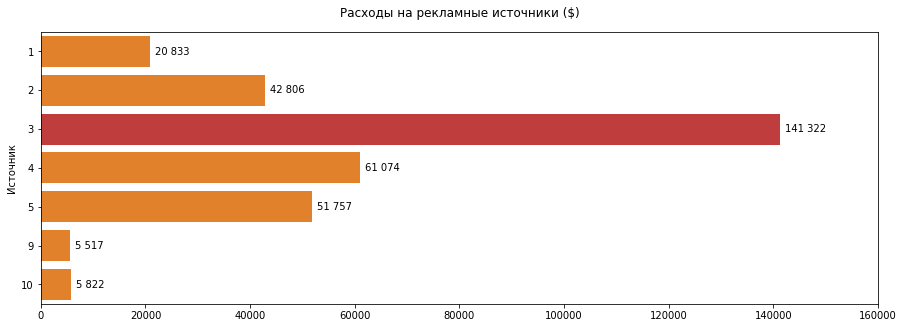

In [51]:
data = costs.groupby('source_id', as_index=0).agg({'costs':'sum'})
colors=[]
for value in data['costs']:
    if value == data['costs'].max():
        colors.append('tab:red')
    else:
        colors.append('tab:orange')

plt.figure(figsize=(15,5))
ax = sns.barplot(data=data, y='source_id', x='costs', orient='h', palette=colors)
plt.title('Расходы на рекламные источники ($)', pad=15)
plt.xlabel('')
plt.ylabel('Источник')
plt.xticks(range(0,160001,20000))

for bars in ax.containers:
    ax.bar_label(bars, labels=[f'{x:,.0f}'.replace(',', ' ') for x in bars.datavalues], padding=5)

plt.show()

**Ответ на вопрос 1:**

Больше всего денег за год было потрачено на источник 3.

### Вопрос 2

2) Найти средний LTV пользователей, которые впервые пришли до декабря 2017 года.

#### Подход 1. Фактический LTV

LTV - это фактическая доходность с момента первого визита пользователя до текущего дня.

In [52]:
#фильтруем пользователей
users_task2 = visits_log[visits_log['Start Ts'] < pd.to_datetime('2017-12-01')].drop_duplicates(subset=['Uid'])
users_task2

,Device,End Ts,source_id,Start Ts,Uid,next_session_start
0,desktop,2017-06-01 00:02:00,5,2017-06-01 00:01:00,13890188992670018146,2018-06-02 00:02:00
1,desktop,2017-06-01 00:02:00,3,2017-06-01 00:02:00,16152015161748786004,2018-06-02 00:02:00
2,desktop,2017-06-01 00:16:00,3,2017-06-01 00:02:00,16706502037388497502,2018-06-02 00:02:00
3,desktop,2017-06-01 00:04:00,3,2017-06-01 00:04:00,8842918131297115663,2018-06-02 00:02:00
4,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,10329302124590727494,2018-06-02 00:02:00
...,...,...,...,...,...,...
154459,desktop,2017-11-30 23:57:00,3,2017-11-30 23:54:00,13186143552490614964,2018-06-02 00:02:00
154460,touch,2017-11-30 23:57:00,4,2017-11-30 23:56:00,5167377733016659042,2018-06-02 00:02:00
154462,desktop,2017-11-30 23:57:00,3,2017-11-30 23:56:00,10016402087785797731,2018-06-02 00:02:00
154464,touch,2017-11-30 23:58:00,2,2017-11-30 23:58:00,10114038727161198939,2018-06-02 00:02:00


In [53]:
#доля от общего числа пользователей
round(users_task2.shape[0] / len(visits_log['Uid'].unique()), 2)

0.47

Подтянем данные о доходности.

In [54]:
users_income = orders_log[orders_log.Uid.isin(users_task2.Uid)].groupby('Uid', as_index=0).agg({'Revenue':'sum'})
users_income.head(3)

,Uid,Revenue
0,10000837700716403746,2.20
1,10001199569370567060,1.00
2,10002243978166172255,17.41


In [55]:
users_task2 = users_task2.merge(users_income, how='left', on='Uid').fillna(0)

Рассмотрим распределение доходов среди пользователей

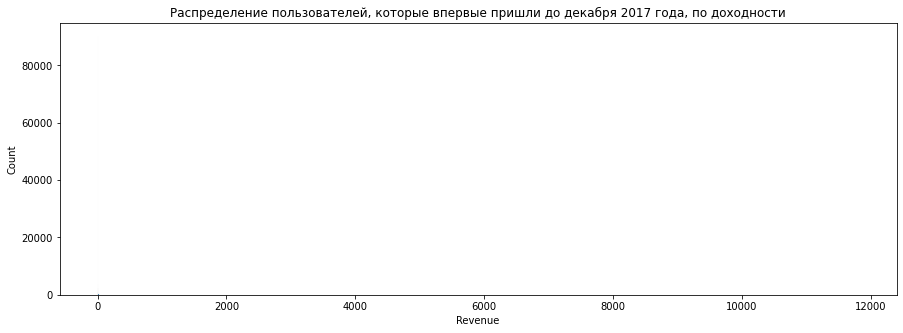

In [56]:
plt.figure(figsize=(15,5))
sns.histplot(data=users_task2, x='Revenue', binwidth=1)
plt.title('Распределение пользователей, которые впервые пришли до декабря 2017 года, по доходности')
plt.show()

Большие выбросы, как и во всем датасете. Рассмотрим левую часть поближе.

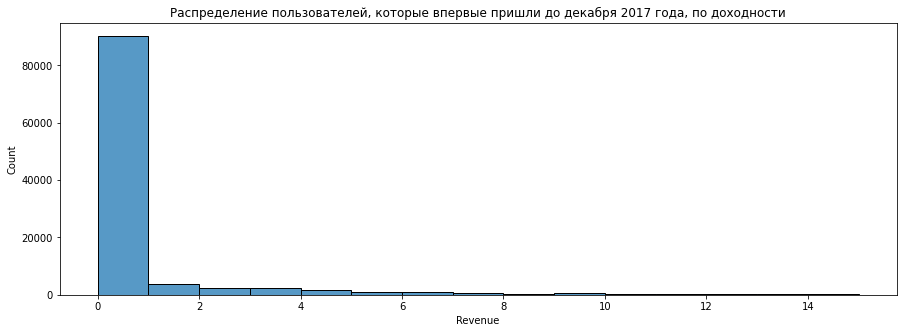

In [57]:
plt.figure(figsize=(15,5))
sns.histplot(data=users_task2.query('Revenue < 15'), x='Revenue', binwidth=1)
plt.title('Распределение пользователей, которые впервые пришли до декабря 2017 года, по доходности')
plt.show()

Следует отметить, что большинство пользователей не делали заказы.

**Ответ на вопрос 2 (подход 1)**

In [58]:
print(f"Cредняя доходность пользователей, которые впервые пришли до декабря 2017 года, составила \
{round(users_task2['Revenue'].mean(), 2)} $")
print(f"При этом доля пользователей, не совершавших заказы, составила \
{round(users_task2.query('Revenue == 0').shape[0] *100 / users_task2.shape[0], 1)} %")

Cредняя доходность пользователей, которые впервые пришли до декабря 2017 года, составила 1.48 $
При этом доля пользователей, не совершавших заказы, составила 82.1 %


Однако, с учетом особенностей распределения, средний показатель доходности по всем клиентам не особенно информативен.

Гораздо более ясную картину даст набор показателей:
- общее количество пользователей
- доля платящих пользователей
- средняя доходность 90+ % платящих пользователей (без учета выбросов)

Распределение доходности платящих пользователей.

In [59]:
users_task2.query('Revenue > 0')['Revenue'].quantile([0.90,0.95,0.99])

0.90    12.22
0.95    18.34
0.99    58.67
Name: Revenue, dtype: float64

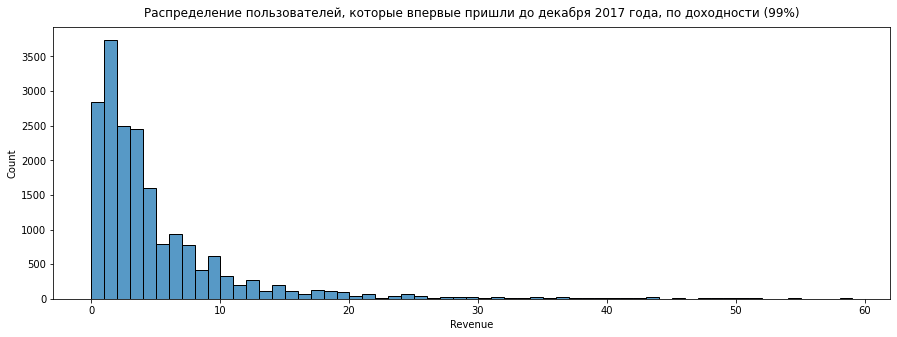

In [60]:
plt.figure(figsize=(15,5))
sns.histplot(data=users_task2.query('Revenue > 0 and Revenue <= 58.67'), x='Revenue', binwidth=1)
plt.title('Распределение пользователей, которые впервые пришли до декабря 2017 года, по доходности (99%)', pad=10)
plt.show()

Ограничимся 99% платящих пользователей.

In [61]:
print(f"Общее количество пользователей, которые впервые пришли до декабря 2017 года, составило \
{'{:,}'.format(users_task2.shape[0]).replace(',', ' ')} пользователей")
print(f"При этом доля пользователей, не совершавших заказы, составила \
{round(users_task2.query('Revenue == 0').shape[0] *100 / users_task2.shape[0], 1)} %")
print(f"Средняя доходность 99% платящих пользователей составила \
{round(users_task2.query('Revenue > 0 and Revenue <= 58.67')['Revenue'].mean(), 2)} $")

Общее количество пользователей, которые впервые пришли до декабря 2017 года, составило 106 509 пользователей
При этом доля пользователей, не совершавших заказы, составила 82.1 %
Средняя доходность 99% платящих пользователей составила 5.14 $


#### Подход 2. Пронозный LTV

LTV - это приведенная стоимость всех будущих потоков дохода, которые отдельный клиент генерирует в течение всего срока использования продукта.

На практике обычно считают LTV на определенный период как пронозную доходность клиентов с текущего дня до конца периода на основании истории его прошлых покупок.

Расчитаем прогнозное количество заказов клиентов на следющий год и прогнозный средний чек. На основе этих показателей получим прогнозный общий доход.

Для построения соответствующих моделей воспользуемся библиотекой lifetimes, которая использует Beta-geometric/negative binomial model (BG/NBD) и Gamma-Gamma model.

Beta-geometric/negative binomial model (BG/NBD) рассчитывает вероятное количество заказов пользователя в будущем на основе частоты его прошлых заказов, времени последнего заказа, вероятности оттока и параметров распределения этих показателей в общем массиве пользователей.

Прежде чем тренировать модель на данных за весь последний год для прогноза на следующий год, проверим предсказательную точность модели для нашего случая на уже известных данных.

Для этого натренируем модель на данных за первые полгода наблюдений и сделаем предсказание на следующие полгода по рассчитанной модели. Затем сравним фактические и смоделированные показатели.

In [62]:
transaction_data = orders_log.loc[:,['Uid','Buy Ts','Revenue']]
transaction_data['Buy Ts'] = transaction_data['Buy Ts'].dt.date
transaction_data = transaction_data.groupby(['Uid','Buy Ts'], as_index=0).agg({'Revenue':'sum'}).query('Revenue > 0')
transaction_data.head(1)

,Uid,Buy Ts,Revenue
0,10000837700716403746,2017-06-21,2.2


In [63]:
transaction_data.apply(['min','max'])

,Uid,Buy Ts,Revenue
min,10000837700716403746,2017-06-01,0.01
max,9999407206938542587,2018-06-01,4079.17


In [64]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'Uid', 'Buy Ts',
                                        calibration_period_end='2017-12-01',
                                        observation_period_end='2018-06-01' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Uid,,,,,
10000837700716403746,0.0,0.0,163.0,0.0,182.0
10001199569370567060,0.0,0.0,6.0,0.0,182.0
10002243978166172255,0.0,0.0,47.0,2.0,182.0
10003351403065971701,0.0,0.0,11.0,0.0,182.0
10003858247064282365,1.0,7.0,31.0,0.0,182.0


In [65]:
summary_cal_holdout.frequency_cal.max()

87.0

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

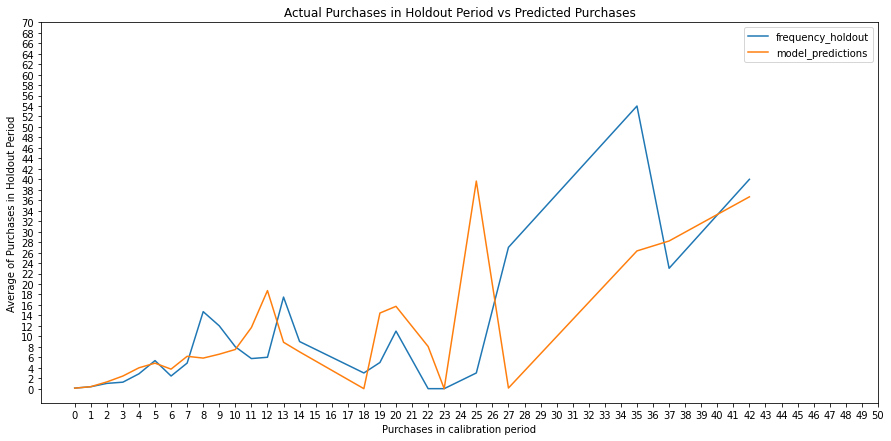

In [66]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=25, figsize=(15,7),
                                               xticks=range(0,51,1), yticks=range(0,71,2))

In [67]:
transaction_data_agg = transaction_data[transaction_data['Buy Ts'] >= pd.to_datetime('2017-12-01')]\
.groupby('Uid', as_index=0).agg({'Buy Ts':'count'})
transaction_data_agg['Buy Ts'].quantile([0,0.5,0.75,0.95,0.99,1])

0.00     1.0
0.50     1.0
0.75     1.0
0.95     2.0
0.99     4.0
1.00    73.0
Name: Buy Ts, dtype: float64

Для абсолютного большинства клиентов прогноз модели по числу платежей довольно точен. Есть выбросы по средним значениям для клиентов, совершивших от 7 заказов за полгода, но их ничтожно мало. 99% клиентов совершили до 4 платежей в тестовом прогнозном периоде.

Натренируем модель на данных за весь год и рассчитаем прогнозный доход от клиентов за следующий год.

In [68]:
transaction_data

,Uid,Buy Ts,Revenue
0,10000837700716403746,2017-06-21,2.20
1,10000997030965831953,2018-01-19,1.83
2,10001199569370567060,2017-11-25,1.00
3,10002243978166172255,2017-10-15,9.16
4,10002243978166172255,2017-12-08,5.50
...,...,...,...
46543,9997777271989789335,2017-11-17,11.61
46544,999906621142257600,2018-01-26,0.98
46545,9999334409150825432,2017-12-06,0.98
46546,9999407206938542587,2018-02-14,0.12


In [69]:
from lifetimes.utils import summary_data_from_transaction_data

data = summary_data_from_transaction_data(transaction_data, 'Uid', 'Buy Ts', 'Revenue', freq='D')
data.head()

,frequency,recency,T,monetary_value
Uid,,,,
10000837700716403746,0.0,0.0,345.0,0.000
10000997030965831953,0.0,0.0,133.0,0.000
10001199569370567060,0.0,0.0,188.0,0.000
10002243978166172255,2.0,56.0,229.0,4.125
10003351403065971701,0.0,0.0,193.0,0.000


monetary_value в модели - это фактический средний чек.

In [70]:
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 36509 subjects, a: 0.94, alpha: 3.73, b: 0.55, r: 0.04>

In [71]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.040496,0.000808,0.038913,0.042080
alpha,3.734616,0.188350,3.365451,4.103781
a,0.944602,0.053009,0.840706,1.048499
b,0.552010,0.037929,0.477670,0.626351


In [72]:
t = 182
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases')

,frequency,recency,T,monetary_value,predicted_purchases
Uid,,,,,
1457537016336779203,23.0,63.0,305.0,9.992609,1.219599e-13
15137372780167445785,11.0,27.0,217.0,8.590000,2.678811e-08
9254819907923411613,10.0,38.0,294.0,5.094000,1.337980e-07
12593176124809752646,22.0,132.0,339.0,13.447727,2.959847e-07
10780884444660069286,12.0,36.0,193.0,2.160833,4.278933e-07
...,...,...,...,...,...
3501596628378158474,82.0,332.0,333.0,8.479878,3.538906e+01
3263486045884611639,105.0,360.0,361.0,9.612000,4.251859e+01
5139615590553126732,104.0,334.0,337.0,7.121923,4.408364e+01


Чтобы убедиться в работоспособности полученной модели, сравним распределение клиентов по количеству заказов из нашего датасета с аналогичным распределением пользователей из искуственно сгенерированного датасета на основе параметров полученной модели.

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

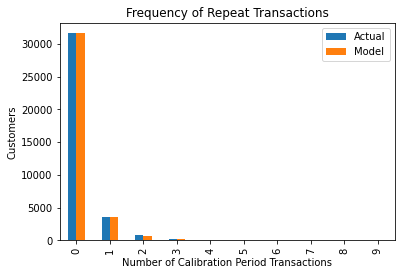

In [73]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency=10)

Мы видим, что сгенерированные моделью данные соответствуют реальному распределению числа платежей среди пользователей.

Теперь с помощью Gamma-Gamma model определим прогнозный средний чек. Эта модель учитывает частоту заказов и фактический средний чек.

Для применения Гамма-Гамма модели убедимся в отсутствии корелляции между количеством повторных заказов и средним чеком.

In [74]:
returning_customers_summary = data.query('frequency > 0')
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.112378
frequency,0.112378,1.000000


Корелляция отсутствует, двигаемся дальше.

Рассчитаем прогнозный средний чек клиентов.

In [75]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4907 subjects, p: 1.71, q: 2.01, v: 2.94>

In [76]:
data['predicted_AVG_check'] = ggf.conditional_expected_average_profit(data['frequency'], data['monetary_value'])

Рассчитаем доходность клиентов за ближайший год на основании полученных данных.

In [77]:
data['predicted_revenue_for_next_year'] = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01,
    freq='D')

In [78]:
data.sort_values('predicted_revenue_for_next_year')

,frequency,recency,T,monetary_value,predicted_purchases,predicted_AVG_check,predicted_revenue_for_next_year
Uid,,,,,,,
1457537016336779203,23.0,63.0,305.0,9.992609,1.219599e-13,9.865974,1.915591e-12
15137372780167445785,11.0,27.0,217.0,8.590000,2.678811e-08,8.404023,3.475932e-07
9254819907923411613,10.0,38.0,294.0,5.094000,1.337980e-07,5.086157,1.082081e-06
10780884444660069286,12.0,36.0,193.0,2.160833,4.278933e-07,2.292346,1.496557e-06
13861787462523859202,35.0,90.0,169.0,5.756857,4.704882e-07,5.743480,4.058828e-06
...,...,...,...,...,...,...,...
6166747268563050393,54.0,64.0,65.0,9.155000,7.002984e+01,9.109371,8.738470e+02
9737640335185488211,37.0,270.0,273.0,35.206486,1.832260e+01,34.729319,1.001875e+03
13519435391454066121,10.0,49.0,50.0,66.223000,1.408974e+01,62.793431,1.189267e+03


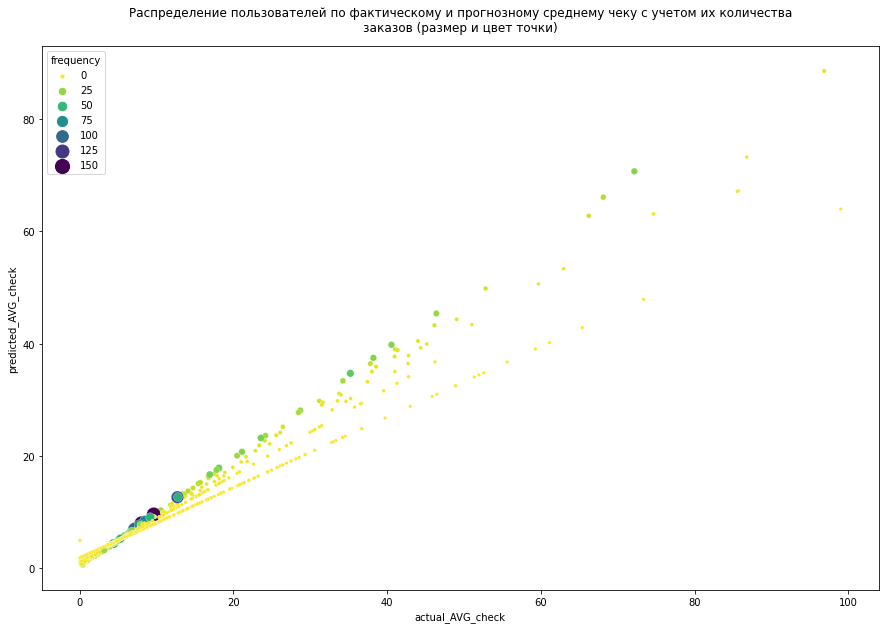

In [79]:
plt.figure(figsize=(15,10))
plt.title(textwrap.fill('Распределение пользователей по фактическому и прогнозному среднему чеку \
с учетом их количества заказов (размер и цвет точки)', 100), pad=15)
sns.scatterplot(data=data.query('monetary_value < 100'), 
                x='monetary_value', y='predicted_AVG_check', 
                hue='frequency', palette='viridis_r',
                size='frequency', sizes=(10,200))
plt.xlabel('actual_AVG_check')
plt.show()

На графике отчетливо видно, что прогнозный средний чек корректировался моделью в меньшую сторону для клиентов, совершивших малое число заказов. 

Точки клиентов, совершивших среднее и большое число заказов, выстроились по биссектрисе между осями с небольшим занижением из-за дисконтирования, заложенного в модель.

**Ответ на вопрос 2 (подход 2)**

In [80]:
print(f"Cредняя прогнозная доходность пользователей, которые впервые пришли до декабря 2017 года, \
на ближайший год составила {round(data['predicted_revenue_for_next_year'].mean(), 2)} $")

Cредняя прогнозная доходность пользователей, которые впервые пришли до декабря 2017 года, на ближайший год составила 1.29 $


Посчитаем показатель только по платящим пользователям и исключим выбросы.

In [81]:
data.query('monetary_value > 0')['predicted_revenue_for_next_year'].quantile([0.90,0.95,0.99,1])

0.90       3.865578
0.95       7.319340
0.99     126.248411
1.00    7909.572366
Name: predicted_revenue_for_next_year, dtype: float64

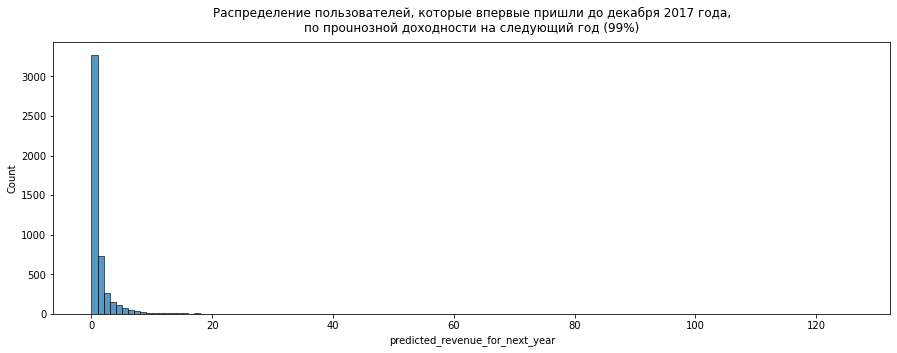

In [82]:
plt.figure(figsize=(15,5))
sns.histplot(data=data.query('monetary_value > 0 and predicted_revenue_for_next_year <= 126.2485'), 
             x='predicted_revenue_for_next_year', binwidth=1)
plt.title(textwrap.fill('Распределение пользователей, которые впервые пришли до декабря 2017 года, \
по проuнозной доходности на следующий год (99%)', 75), pad=10)
plt.show()

Ограничимся 99% платящих пользователей.

In [83]:
mean2 = round(data.query('monetary_value > 0 and predicted_revenue_for_next_year <= 126.2485')\
['predicted_revenue_for_next_year'].mean(), 2)

print(textwrap.fill(f"Средняя прогнозная доходность 99% платящих пользователей, которые впервые пришли до \
декабря 2017 года, на следующий год составила {mean2} $", 105))

Средняя прогнозная доходность 99% платящих пользователей, которые впервые пришли до декабря 2017 года, на
следующий год составила 1.92 $


Прогнозная доходность значительно ниже фактической по текущим клиентам из-за рассчитанной моделью вероятности оттока.

### Вопрос 3

3) Какая кагорта (по месяцам первого посещения) принесла больше всего денег за полгода жизни?

Получим данные по первым визитам пользователей и определим когорты.

In [84]:
# данные уже отсортированы по дате, поэтому просто удалим дубликаты по id 
# таким образом получим первые сессии пользователей
cohort_mapping = visits_log.drop_duplicates(subset=['Uid'])
cohort_mapping['cohort'] = cohort_mapping['Start Ts'].dt.to_period('M').apply(str)
cohort_mapping = cohort_mapping[['Uid','Start Ts','cohort']].rename(columns={'Start Ts':'first_visit'})
cohort_mapping

,Uid,first_visit,cohort
0,13890188992670018146,2017-06-01 00:01:00,2017-06
1,16152015161748786004,2017-06-01 00:02:00,2017-06
2,16706502037388497502,2017-06-01 00:02:00,2017-06
3,8842918131297115663,2017-06-01 00:04:00,2017-06
4,10329302124590727494,2017-06-01 00:09:00,2017-06
...,...,...,...
359395,83872787173869366,2018-05-31 23:59:00,2018-05
359396,3720373600909378583,2018-05-31 23:59:00,2018-05
359397,10723414689244282024,2018-05-31 23:59:00,2018-05
359398,10406407303624848652,2018-05-31 23:59:00,2018-05


Подтянем к данным о платежах и отфильтруем платежи за первые полгода жизни пользователя.

In [85]:
data_task3 = orders_log.merge(cohort_mapping, how='left', on='Uid')[['Uid','cohort','first_visit','Buy Ts','Revenue']]
# вычисляем разницу между временем платежа и временем первого визита в днях
data_task3['days_from_1st_visit'] = (data_task3['Buy Ts'] - data_task3['first_visit']).dt.days
# оставляем только платежи менее 365/2 дней с даты первого визита
data_task3 = data_task3.query('days_from_1st_visit < 365/2')
data_task3['days_from_1st_visit'].value_counts().sort_index()

0      28103
1       1422
2        837
3        628
4        532
       ...  
178       53
179       43
180       41
181       48
182       59
Name: days_from_1st_visit, Length: 183, dtype: int64

Получили данные о платежах клиентов, совершенных в первые полгода жизни.

In [86]:
data_task3.query('days_from_1st_visit > 0')

,Uid,cohort,first_visit,Buy Ts,Revenue,days_from_1st_visit
106,12580826049914769163,2017-06,2017-06-01 08:22:00,2017-06-02 09:41:00,1.83,1
139,3644482766749211722,2017-06,2017-06-01 09:22:00,2017-06-02 12:44:00,0.85,1
155,3644482766749211722,2017-06,2017-06-01 09:22:00,2017-06-02 15:08:00,12.83,1
173,10042262218052845742,2017-06,2017-06-01 12:53:00,2017-06-02 17:39:00,0.30,1
176,3738863118490040629,2017-06,2017-06-01 12:30:00,2017-06-02 17:58:00,2.69,1
...,...,...,...,...,...,...
50402,656193162812616454,2018-05,2018-05-02 09:08:00,2018-05-31 23:29:00,2.75,29
50403,5300693976971713685,2018-05,2018-05-30 22:31:00,2018-05-31 23:30:00,5.50,1
50404,14926823272464019002,2018-05,2018-05-29 12:09:00,2018-05-31 23:36:00,0.61,2
50406,13121453305610619664,2018-03,2018-03-13 15:34:00,2018-05-31 23:40:00,1.16,79


Агрегируем доход по когортам и визуализируем отчет.

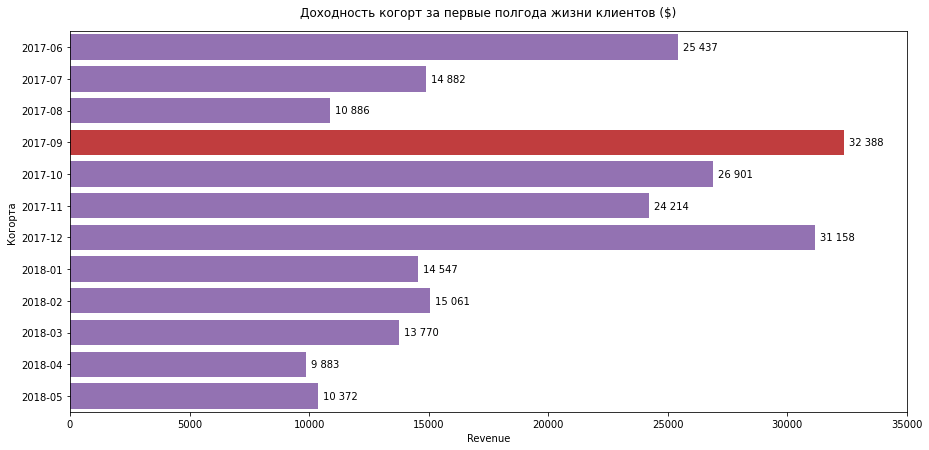

In [87]:
data = data_task3.groupby('cohort', as_index=0).agg({'Revenue':'sum'})
colors=[]
for value in data['Revenue']:
    if value == data['Revenue'].max():
        colors.append('tab:red')
    else:
        colors.append('tab:purple')

plt.figure(figsize=(15,7))
ax = sns.barplot(data=data, y='cohort', x='Revenue', orient='h', palette=colors)
plt.title('Доходность когорт за первые полгода жизни клиентов ($)', pad=15)
plt.ylabel('Когорта')
plt.xticks(range(0,35000+1,5000))

for bars in ax.containers:
    ax.bar_label(bars, labels=[f'{x:,.0f}'.replace(',', ' ') for x in bars.datavalues], padding=5)

plt.show()

**Ответ на вопрос 3:**

Когорта от 2017-09 принесла больше всего денег за полгода жизни пользователей.